In [1]:
import numpy as np
from scipy import linalg, stats
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from tqdm.notebook import tqdm, trange
import time
import itertools
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle as pkl

## Simulating Additive Effects and Higher Rank Matrices

In [2]:
class tools:
    def outer(mat, weights, tensor = False, skip = None):
        (m, k) = mat.shape
        matType = torch if tensor else np
        ret = torch.zeros(m, m) if tensor else np.zeros(shape = (m, m))
        
        for i in range(k):
            for j in range(k):
                if i == skip or j == skip:
                    continue
                    
                u = mat[:, i]
                v = mat[:, j]
                ret += weights[i, j] * matType.outer(u, v)
                
        return ret
    
    def evalAcc(p1, p2):
        maxCorr = 0
        if p1.shape[1] != p2.shape[1]:
            print('error: wrong dimensions')
            return
        
        k = p1.shape[1]

        for perm in itertools.permutations(range(k)):
            p1_perm = p1[:,perm].reshape(-1,)
            r = stats.pearsonr(p1_perm, p2.reshape(-1,))[0]
            rsquared = r ** 2
            if rsquared > maxCorr: 
                maxCorr = rsquared
                best_perm = perm

        return maxCorr

In [3]:
class Dataset:
    def __init__(self, n, m, k = 2,
                 h2 = 1, noise_beta = 0, noise_omega = 0, additive_model_var = 0.5,
                 sparse = 0, self_interactions = True):
        self.n = n
        self.m = m
        self.k = k
        self.h2 = h2
        self.sparse = sparse
        self.noise_beta = noise_beta
        self.noise_omega = noise_omega
        self.additive_model_var = additive_model_var
        self.self_interactions = self_interactions

        self.simGeno()
        self.simEffects()
        self.simPheno()

    def simGeno(self):
        # genotypes are iid binom(2, p) where p normal
        # genotypes are scaled and centered

        geno = np.zeros([self.n, self.m])
        for i in range(self.m):
            p = np.random.beta(2, 2)
            snps = np.random.binomial(2, p, self.n)
            geno.T[i] = (snps - (2*p))/np.sqrt(2*p*(1-p))

        # interaction effects as khatri rao
        inter = linalg.khatri_rao(geno.T, geno.T).T
        self.geno, self.inter = geno, inter

    def simEffects(self):
        m = self.m
        k = self.k

        # simulated latent pathways
        pathways = np.random.normal(0, 1, (m, k))
        sparse = np.random.uniform(0, 1, (m, k)) > self.sparse
        pathways = pathways * sparse

        # add in anchor snps
        pathways[-k:, :] = np.diag(np.random.normal(size = k))

        # main effects as sum of pathways
        beta = np.sum(pathways, axis=1, keepdims=True)

        # generate weights from normal (0, 1)
        weights = np.random.normal(0, 1, size = (k, k))
        offset = 0 if self.self_interactions else -1 
        weights = np.tril(weights, offset) + np.tril(weights, -1).T

        # simulate interaction matrix by summing over weighted outerproducts
        omega = tools.outer(pathways, weights)

        # adding gaussian noise to additive and epistatic effects
        var_eomega = np.var(omega) * (self.noise_omega/ (1 - self.noise_omega)) 
        eomega = np.random.normal(0, np.sqrt(var_eomega), m * m).reshape(m, -1)
        eomega = np.tril(eomega) + np.tril(eomega, -1).T
        
        var_ebeta = np.var(beta) * (self.noise_beta/ (1 - self.noise_beta)) 
        ebeta = np.random.normal(0, np.sqrt(var_ebeta), m).reshape(-1, 1)
        
        # scale additive and epistatic effect sizes
        e_var = np.var(self.inter @ (omega + eomega).reshape(-1, 1))
        a_var = np.var(self.geno @ (beta + ebeta))
        
        scale = np.sqrt((a_var/self.additive_model_var - a_var)/e_var)
        weights *= scale
        eomega *= scale
        omega = tools.outer(pathways, weights)
        
        
        # instance variables
        self.pathways = pathways
        self.beta = beta + ebeta
        self.omegaMat = omega + eomega
        self.omega = self.omegaMat.reshape(-1, 1)
        self.weights = weights
        self.normalizePheno()
        
    
    def normalizePheno(self):
        # normalize phenotypes to variance 1
        std_mean = np.std(self.inter @ self.omega + self.geno @ self.beta)
        scale = std_mean / np.sqrt(self.h2)
        self.pathways /= scale
        self.weights *= scale
        self.beta /= scale
        self.omegaMat /= scale

    def simPheno(self):
        # model with main effects and interactions
        mean = self.inter @ self.omega + self.geno @ self.beta

        # add noise to simulate heritability
        eps_std = np.sqrt(1 - self.h2)
        noise = np.random.normal(0, eps_std, self.n).reshape(-1, 1)
        self.pheno = mean + noise
        
        

## Model

In [4]:
class Decomp:
    def __init__(self):
        self.loss = None
        self.conv = True
        self.pathways = None
        self.weights = None
    
    def coordDescent(self, data, progress = False):
        m = data.m
        k = data.k

        G = data.geno
        inter = data.inter
        Y = data.pheno#.reshape(-1, 1)

        tol = 1e-5

        # initialize pathways and weights
        weights = np.random.normal(0, 0.1, size = (k, k))
        weights = np.tril(weights, -1) + np.tril(weights, -1).T
        pathways = np.random.normal(0, 0.1, size = (m, k))
        iterations = 0

        prevLoss = currentLoss = self.getLoss(data, pathways, weights, tensor = False)
        lossList = [currentLoss]

        while(True):
            # iteratively update each pathway
            for i in range(k):
                # compute constants
                mask = [True] * k
                mask[i] = False
                C1 = tools.outer(pathways, weights, skip=i).reshape(-1, 1)
                C1 = inter @ C1
                C2 = G @ np.sum(pathways[:,mask], axis=1, keepdims=True) 
                C = C1 + C2
                A = np.sum(G @ pathways @ np.diagflat(weights[i]), axis=1, keepdims=True)

                # equations from the first order conditions
                u1 = (4 * G.T @ (A*A*G)) + (4 * G.T @ (A*G)) + (G.T @ G)
                u2 = (2 * (A*G).T @ Y) + (G.T @ Y) - (2 * (A*G).T @ C) - (G.T @ C)
                u = linalg.inv(u1) @ u2
                u[m-k+i] = 0
                pathways[:, i] = u.reshape(-1,)

            weights = self.getWeights(data, pathways, diag = False)

            # monitor convergence
            iterations += 1

            prevLoss = currentLoss
            currentLoss = self.getLoss(data, pathways, weights, tensor = False)
            lossList.append(currentLoss)

            if np.abs(currentLoss - prevLoss) < tol: break
            if iterations > 10000: break
            if progress and iterations % 100 == 0:
                print("(iterations,loss):", iterations, round(currentLoss, 3))

        self.loss = lossList
        self.pathways = pathways
        self.weights = weights

    def gradDescent(self, data, reg = 0, progress = False, analyticalWeights = False):
        m = data.m
        k = data.k

        G = torch.tensor(data.geno, requires_grad = False).double()
        inter = torch.tensor(data.inter, requires_grad = False).double()
        Y = torch.tensor(data.pheno, requires_grad = False).double()

        tol = 1e-4
        
        # for anchor snps
        mask = torch.ones(size = (m, k))
        mask[-k:, :] = torch.eye(k)
        
        # initialization
        weights = np.random.normal(0, 0.1, size = (k, k))
        weights = np.tril(weights, -1) + np.tril(weights, -1).T
        weights = torch.tensor(weights, requires_grad = True)

        pathways = np.random.normal(0, 0.1, size = (m, k))
        pathways *= mask.detach().numpy()
        pathways = torch.tensor(pathways, requires_grad = True)
        
        # use Adam to optimize 
        params = [pathways] if analyticalWeights else [weights, pathways]
        optimizer = optim.Adam(params)
        prevLoss = currentLoss = self.getLoss(data, pathways, weights).item()
        
        lossList = [currentLoss]
        iterations = 0

        conv = True
        
        while True:            
            iterations += 1
            
            if analyticalWeights: 
                weights = torch.tensor(self.getWeights(data, pathways.detach().numpy()))
            loss = self.getLoss(data, pathways * mask, weights, reg = reg)
            
            # optimize the loss function with gradient descent
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # monitor convergence
            prevLoss = currentLoss
            currentLoss = loss.item()
            lossList.append(currentLoss)
            
            #if np.abs(currentLoss - prevLoss) < tol and iterations > 1: break
            if iterations % 1000 == 0 and progress: 
                print("(iterations,loss):", iterations, round(loss.item(), 3))
                
            if iterations > 15000: break

        pathways = pathways.detach().numpy()
        weights = weights.detach().numpy()
        
        self.loss = lossList
        self.pathways = pathways
        self.weights = weights
        self.conv = conv
        
    def getWeights(self, data, pathways, diag = True):
        G = data.geno
        Y = data.pheno
        k = data.k
        
        beta = pathways.sum(axis = 1, keepdims = True)
        
        Z = Y - G @ beta
        X = linalg.khatri_rao((G @ pathways).T, (G @ pathways).T).T
        
        offset = 0 if diag else -1
        
        indices = np.nonzero(np.tril(np.ones(k), offset).reshape(-1,))[0]
        X = X[:, indices]

        lr = LinearRegression(fit_intercept=True)
        lr.fit(X, Z)
        
        weightsTril = lr.coef_.reshape(-1,)
        weights = np.zeros((k, k))
        weights[np.tril_indices(k, offset)] = weightsTril
        weights[np.tril_indices(k, -1)] *= 1/2
        weights = weights + np.tril(weights, -1).T
        return weights

        
        
    def getLoss(self, data, pathways, weights, reg = 0, tensor = True):
        G = torch.tensor(data.geno) if tensor else data.geno
        Y = torch.tensor(data.pheno) if tensor else data.pheno
        inter = torch.tensor(data.inter) if tensor else data.inter
        n = data.n

        if tensor:
            interEffect = tools.outer(pathways, weights, tensor=tensor).view(-1, 1).double()
            interEffect = inter @ interEffect
            mainEffect = torch.sum(G @ pathways, dim=1, keepdims=True)
            penalty = reg * torch.sum(torch.abs(pathways))
            loss = torch.norm(Y - mainEffect - interEffect)**2 + reg
        else:
            interEffect = tools.outer(pathways, weights, tensor=tensor).reshape(-1, 1)
            interEffect = inter @ interEffect
            mainEffect = np.sum(G @ pathways, axis=1, keepdims=True)
            penalty = reg * np.sum(np.abs(pathways))
            loss = linalg.norm(Y - mainEffect - interEffect)**2 + reg
        
        return loss
    
    def evalAcc(self, data):
        return tools.evalAcc(self.pathways, data.pathways)
    
    def plotLoss(self):
        plt.plot(self.loss)
        plt.show()

In [88]:
data = Dataset(1000, 10, k = 3)
data.pathways

array([[-0.10628393, -0.13681869, -0.01938696],
       [-0.1997796 , -0.03487384, -0.12278201],
       [-0.03908214,  0.01852343, -0.09313779],
       [-0.06712074, -0.14207255, -0.11845818],
       [ 0.09480329, -0.04371697,  0.34023964],
       [-0.00955867,  0.23565234, -0.21407495],
       [ 0.11143469,  0.00469344, -0.08172946],
       [-0.27522153,  0.        ,  0.        ],
       [ 0.        , -0.13725186,  0.        ],
       [ 0.        ,  0.        ,  0.07545817]])

## K = 2 and K = 3

In [62]:
for i in trange(5):
    for k in [4]:
        for self_interactions in [False, True]:
            prefix = 'self_interactions' if self_interactions else 'no_self_interactions'
            name = './pkl/%s_k%d_dataset%d.pkl' % (prefix, k, i)
            print(name)
            data = Dataset(10000, 20, k = k, self_interactions=self_interactions)
            decomp = Decomp()
            res_loss = list()
            res_acc = list()
            for j in range(10):
                decomp.gradDescent(data)
                acc = decomp.evalAcc(data)
                loss = decomp.loss
                res_acc.append(acc)
                res_loss.append(loss)

            res = np.vstack([np.array(res_loss).T, np.array(res_acc)])
        
            with open(name, 'wb') as f:
                pkl.dump(res, f)



  0%|          | 0/5 [00:00<?, ?it/s]

./pkl/no_self_interactions_k4_dataset0.pkl
./pkl/self_interactions_k4_dataset0.pkl
./pkl/no_self_interactions_k4_dataset1.pkl
./pkl/self_interactions_k4_dataset1.pkl
./pkl/no_self_interactions_k4_dataset2.pkl
./pkl/self_interactions_k4_dataset2.pkl
./pkl/no_self_interactions_k4_dataset3.pkl
./pkl/self_interactions_k4_dataset3.pkl
./pkl/no_self_interactions_k4_dataset4.pkl
./pkl/self_interactions_k4_dataset4.pkl


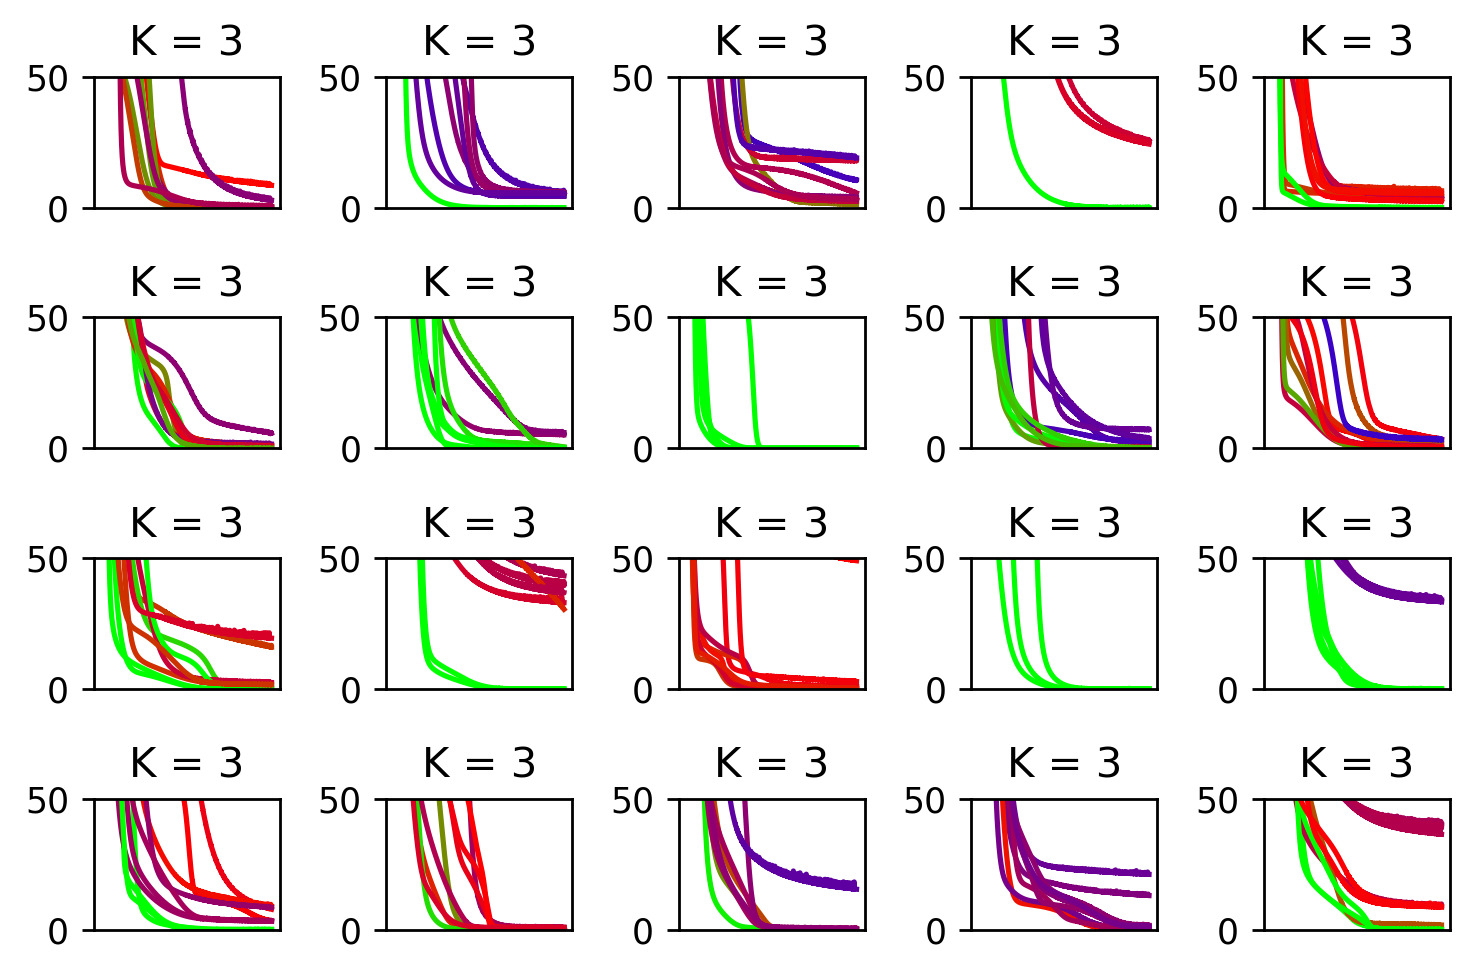

In [90]:
plt.figure(dpi = 250)
index = 1

for k in [3]:
    for self_interactions in [False, True]:
        for i in range(10):
            prefix = 'self_interactions' if self_interactions else 'no_self_interactions'
            name = './pkl/%s_k%d_dataset%d.pkl' % (prefix, k, i)
            with open(name, 'rb') as f:
                res = pkl.load(f)
                plt.subplot(4, 5, index)
                for j in range(10):
                    plt.plot(res[:-1, j], c = plt.cm.brg(res[-1, j]))
                    plt.ylim(0, 50)
                    plt.title('K = %d' %k)
                    plt.xticks([])
                    plt.tight_layout()
            index += 1

In [64]:
index = 1
for k in [4]:
    for self_interactions in [False, True]:
        for i in range(5):
            prefix = 'self_interactions' if self_interactions else 'no_self_interactions'
            name = '%s_k%d_dataset%d' % (prefix, k, i)
            with open('./pkl/%s.pkl' % name, 'rb') as f:
                plt.figure(dpi = 250)
                res = pkl.load(f)
                for j in range(10):
                    plt.plot(res[:-1, j], c = plt.cm.brg(res[-1, j]))
                    plt.ylim(0, 50)
                    plt.title(name)
                    plt.tight_layout()
                plt.savefig('./plots/%s.png' % name)
                plt.close()
            index += 1

[[2.48694814e-02 8.54098996e+00 7.16429730e-03 2.51912364e-01
  2.83007085e+00 8.69724982e-03 9.57347869e-03 1.76448246e-01
  1.92430254e-02 4.41669837e-01]
 [5.78987688e-01 5.06688449e-01 7.79162055e-01 2.96951267e-01
  2.72284093e-01 8.11097695e-01 7.87855534e-01 3.08266809e-01
  6.15582580e-01 3.43708028e-01]]


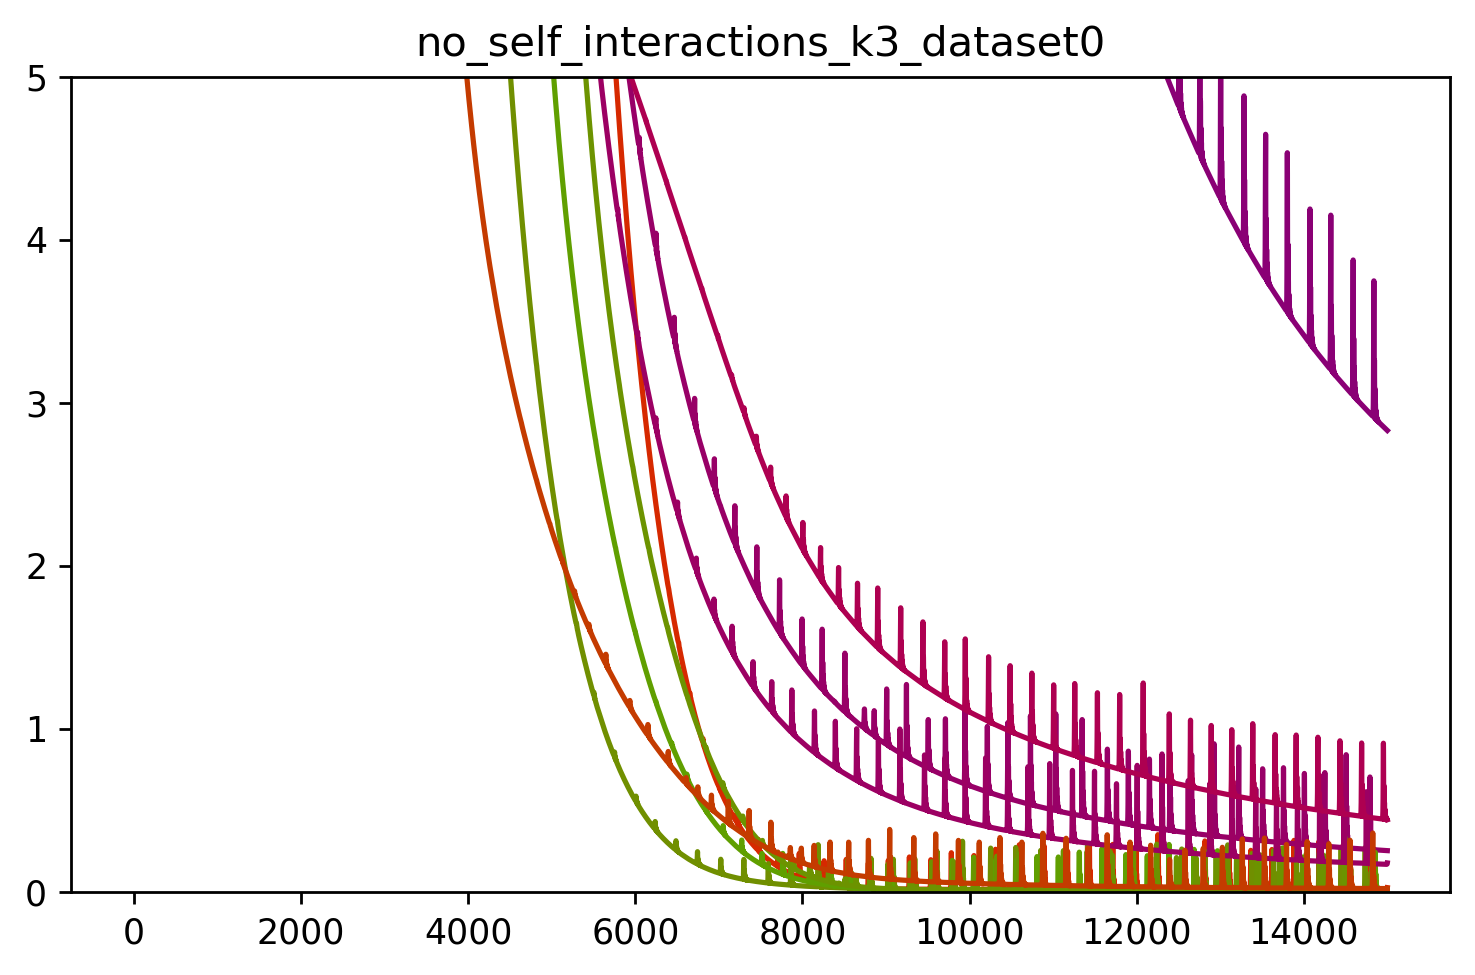

In [85]:
k = 3
i = 0
self_interactions = False
prefix = 'self_interactions' if self_interactions else 'no_self_interactions'
name = '%s_k%d_dataset%d' % (prefix, k, i)
plt.figure(dpi = 250)
with open('./pkl/%s.pkl' % name, 'rb') as f:
    res = pkl.load(f)
    for j in range(10):
        plt.plot(res[:-1, j], c = plt.cm.brg(res[-1, j]))
        plt.ylim(0, 5)
        plt.title(name)
        plt.tight_layout()
    print(res[-2:,])
    plt.show()
    

## Optimization

In [210]:
data = Dataset(10000, 20, 3)

In [213]:
decomp = Decomp()
decomp.coordDescent(data)
decomp.evalAcc(data)

0.6115325724789005

In [214]:
decomp.pathways

array([[-0.47620849,  0.33991789,  0.08019405],
       [ 0.24560349, -0.30151927, -0.04854671],
       [-0.32808694,  0.13017015,  0.0479413 ],
       [-0.26113468, -0.10098503, -0.03897394],
       [-0.06781313,  0.03136368, -0.00689626],
       [ 0.08819827, -0.04890943, -0.01384938],
       [ 0.44370056, -0.1801525 , -0.02494485],
       [ 0.47763772, -0.07265854, -0.03883988],
       [ 0.33438418, -0.34868118, -0.11236356],
       [-0.03985423, -0.16529533, -0.01806477],
       [ 0.20073612, -0.13508175, -0.03344093],
       [-0.11595448, -0.01216064, -0.01040865],
       [-0.16089473,  0.19158719,  0.03517348],
       [ 0.10361176, -0.09038895,  0.01073668],
       [-0.12426331,  0.10771784, -0.00569733],
       [-0.07369833, -0.13204023, -0.04029537],
       [ 0.11847759, -0.00182372, -0.01180372],
       [-0.00063784, -0.03553048, -0.00432049],
       [-0.05877748,  0.02220549,  0.00701994],
       [ 0.04271311,  0.01480985,  0.01151857]])

## Anchor SNPs

In [158]:
for k in [2, 3, 4]:
    data = Dataset(10000, 20, k = k)
    decomp = Decomp()
    res_loss = list()
    res_acc = list()
    for j in trange(10):
        decomp.gradDescent(data)
        acc = decomp.evalAcc(data)
        loss = decomp.loss
        res_acc.append(acc)
        res_loss.append(loss)

    res = np.vstack([np.array(res_loss).T, np.array(res_acc)])

    with open('./pkl/anchor_k%d_1.pkl' % k, 'wb') as f:
        pkl.dump(res, f)

        

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

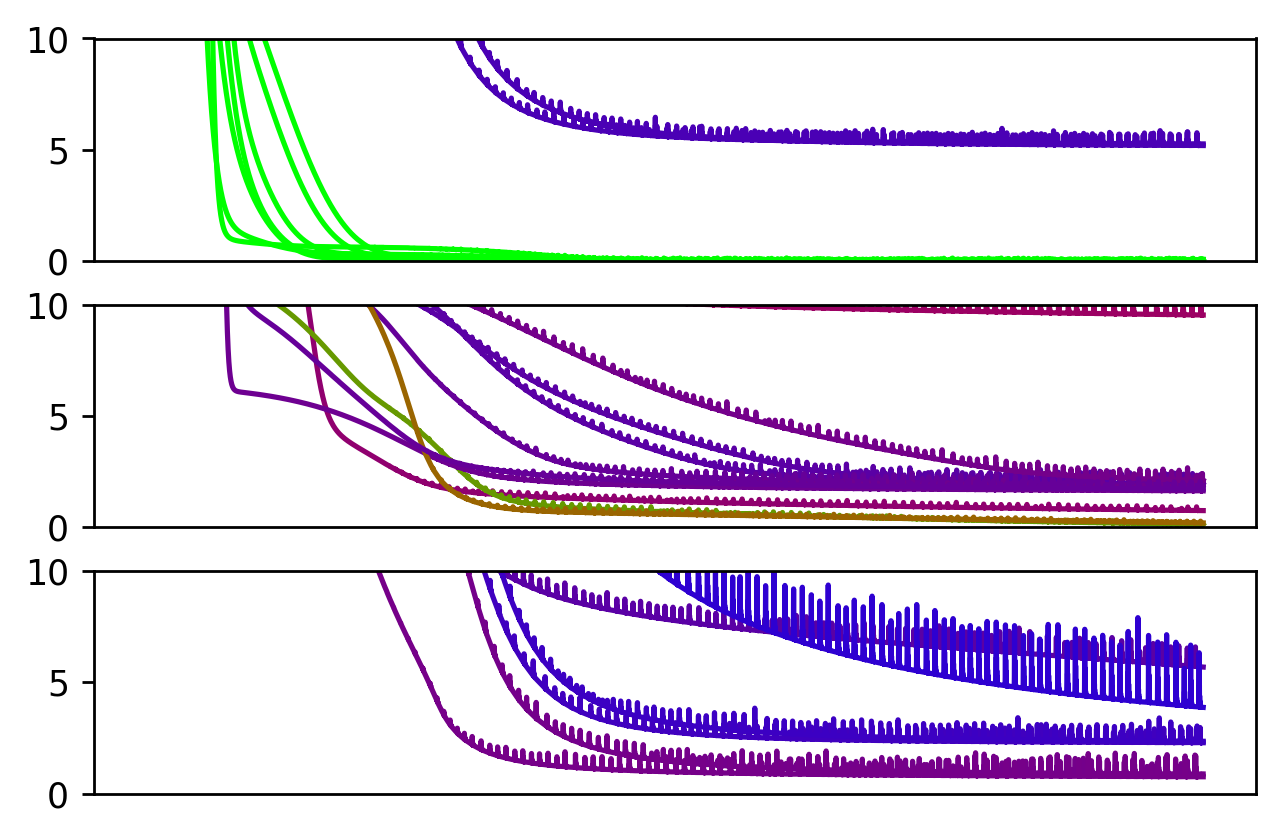

In [185]:
plt.figure(dpi = 250)
for k in [2, 3, 4]:
    with open('./pkl/anchor_k%d_1.pkl' % k, 'rb') as f:
        res = pkl.load(f)
        plt.subplot(3, 1, k-1)
        for i in range(10):
            plt.plot(res[:-1, i], c = plt.cm.brg(res[-1, i]))
            plt.ylim(0, 10)
            plt.xticks([])

In [171]:
k = 4
with open('./pkl/anchor_k%d_1.pkl' % k, 'rb') as f:
    res = pkl.load(f)
    print(res[-1,:])
    print(res[-2,:])

[0.17631697 0.24850077 0.22751707 0.2536964  0.12835199 0.0928865
 0.22978102 0.2028066  0.11796549 0.23314515]
[  5.69399982  96.06586046 175.24006418  78.30086339   2.28726102
   3.87994981   0.87565823  92.69814872   2.35129253   0.7527068 ]


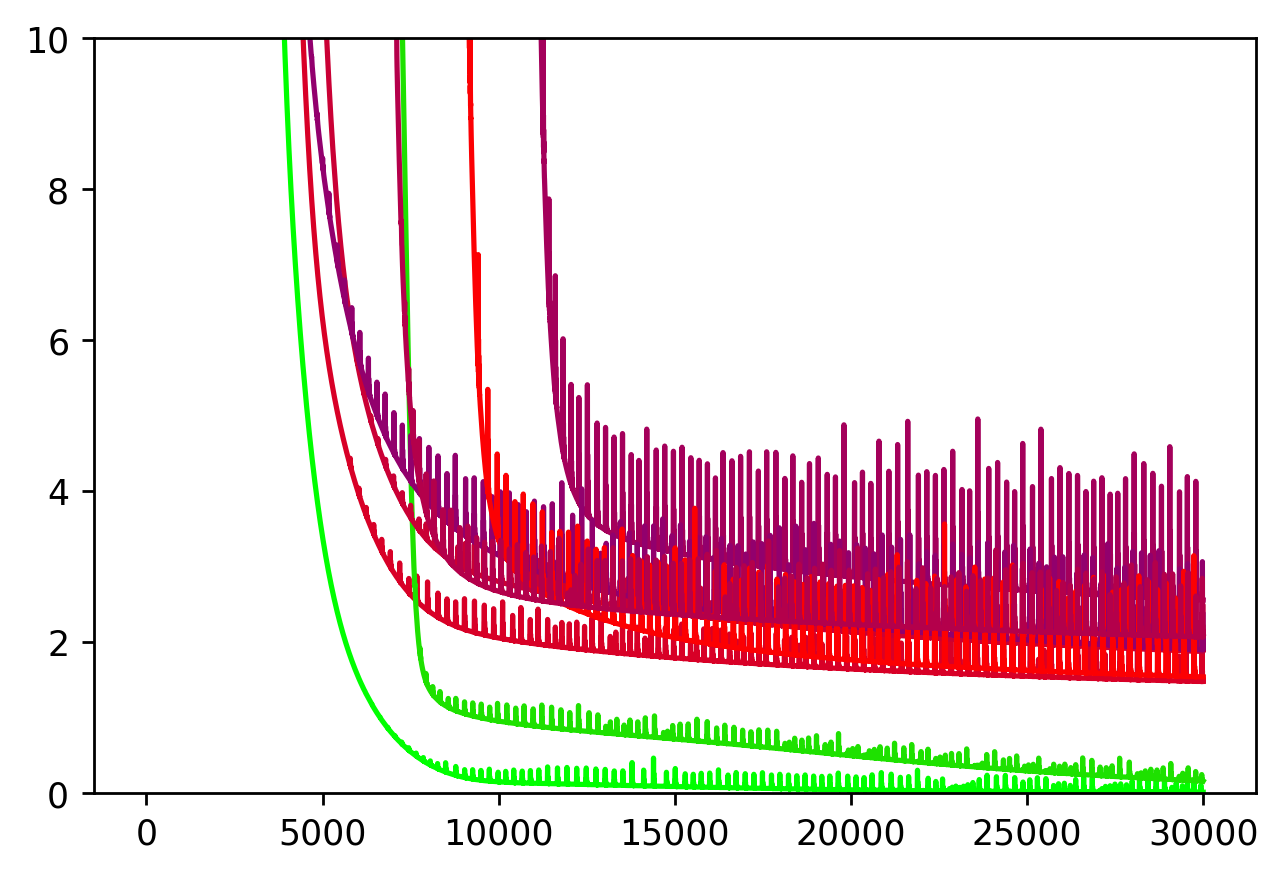

In [172]:
k = 4
plt.figure(dpi = 250)
with open('./pkl/anchor_k%d.pkl' % k, 'rb') as f:
    res = pkl.load(f)
    for i in range(10):
        plt.plot(res[:-1, i], c = plt.cm.brg(res[-1, i]))
        plt.ylim(0, 10)

In [147]:
res

array([[1.40491474e+04, 2.12365624e+04, 1.72041893e+04, ...,
        1.84628033e+04, 2.77355788e+04, 2.04394381e+04],
       [1.40491474e+04, 2.12365624e+04, 1.72041893e+04, ...,
        1.84628033e+04, 2.77355788e+04, 2.04394381e+04],
       [1.38174406e+04, 2.09182361e+04, 1.69079451e+04, ...,
        1.81635810e+04, 2.73309186e+04, 2.01307191e+04],
       ...,
       [1.05429568e+02, 7.09622738e+01, 6.17802424e-03, ...,
        1.89887920e+00, 1.53392514e+00, 2.06366242e+00],
       [1.05568743e+02, 7.09619882e+01, 6.19403563e-03, ...,
        1.93983240e+00, 1.53391072e+00, 2.06580967e+00],
       [3.76041380e-01, 2.82838361e-01, 9.97089751e-01, ...,
        2.86272485e-01, 4.92971823e-01, 3.52970632e-01]])

In [ ]:
with open('./pkl/anchor_k%d.pkl' % k, 'rb') as f:
    pkl.load
    

In [177]:
print(res[998:1001])

[[434.34390981 278.0649464  296.2271624  652.53712699 106.96110502
  448.68357191 177.75310105 504.18454719 492.90902081 181.52236245]
 [433.84205871 277.826386   296.1446946  651.42913522 106.87542244
  447.86453503 177.54717598 503.63552193 492.43310029 181.33583512]
 [433.34212369 277.58847539 296.06222288 650.31925318 106.79001965
  447.04445978 177.34172361 503.08716193 491.95871431 181.14979677]
 [432.84400964 277.35120595 295.97972376 649.20750557 106.70490403
  446.22334656 177.13674652 502.53944427 491.4858073  180.96428853]]


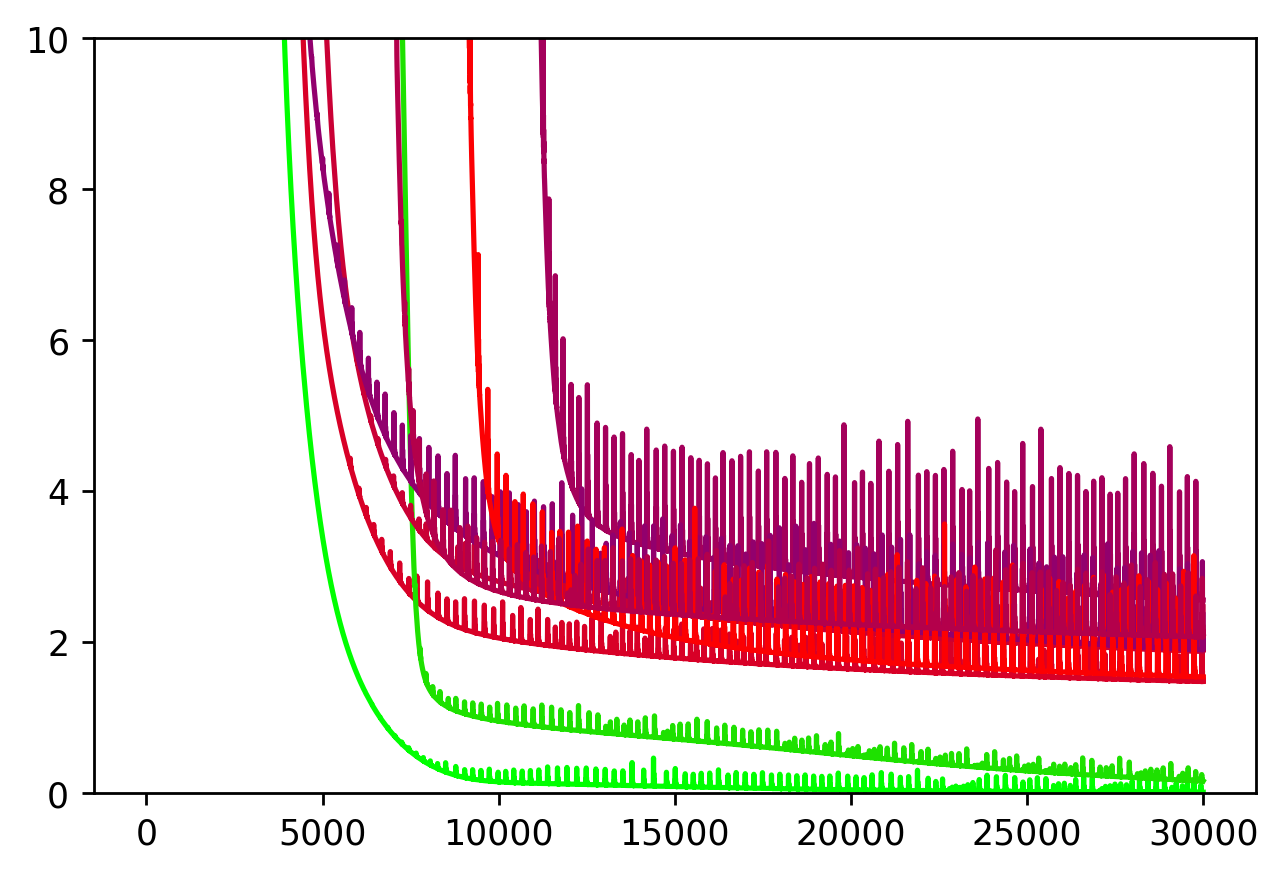

In [181]:
plt.figure(dpi = 250)
for i in range(10):
    plt.plot(res[:-1, i], c = plt.cm.brg(res[-1, i]))
    plt.ylim(0, 10)

In [ ]:
plt.cm.

In [133]:
res[-1, :]

array([0.22128423, 0.9964909 , 0.43108555, 0.33238075, 0.34604202,
       0.20404429, 0.52311042, 0.27296551, 0.18496903, 0.30863467])

In [134]:
res[-2, :]

array([3.04416966e+00, 1.91220627e-03, 7.02845449e-02, 1.04120749e-01,
       1.51474021e+02, 1.57087302e-01, 7.42075782e-02, 1.57593541e+02,
       2.28656841e-01, 4.04721289e+00])

In [108]:
res[:-2].shape

(15001, 10)

## Regularization

In [ ]:
"""
with repeats
"""

res_corr = dict()
res_pred = dict()
grid = np.logspace(1, 4, 10)
for reg in tqdm(grid):
    acc_cor = list()
    sel_cor = list()
    pred_list = list()
    for i in trange(10):
        data = Dataset(10000, 10, k=3, h2=1, sparse = 0.2)
        acc_list = list()
        for j in range(10):
            res = Decomp.gradDescent(data, reg = reg)    
            pathways = res['pathways']
            loss = res['loss'][-1]
            acc = tools.evalAcc(pathways, data.pathways)
            acc_list.append((loss, acc['corr'], acc['p1_comp'], acc['p2_comp'], acc['sel_match']))
            
        acc_list = np.array(acc_list)
        pred_cor = sorted(acc_list, key = lambda x: x[0])[0][1]
        pred_sel = sorted(acc_list, key = lambda x: x[0])[0][4]
        pred_list.append((pred_cor, pred_sel))
        acc_cor.append(stats.spearmanr(acc_list[:,0], acc_list[:,1])[0])
        sel_cor.append(stats.spearmanr(acc_list[:,0], acc_list[:,4])[0])
    
    res_corr[reg] = (np.mean(acc_cor), np.std(sel_cor))
    res_pred[reg] = pred_list
    
    with open('./res_corr_20.pkl', 'wb') as f:
        pkl.dump(res_corr, f)

    with open('./res_pred_20.pkl', 'wb') as f:
        pkl.dump(res_pred, f)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
"""
without repeats
"""
plots = dict()
grid = np.logspace(-8, 8, 20)

for i in trange(20):
    data = Dataset(10000, 10, k=2, h2=1, sparse = 0)
    for reg in grid:
        res = Decomp.gradDescent(data, reg = reg)    
        pathways = res['pathways']
        loss = res['loss'][-1]
        acc = tools.evalAcc(pathways, data.pathways)
        
        pred_list = plots.get(reg, list())
        pred_list.append(acc['corr'])
        plots[reg] = pred_list
    
    with open('./res_00_k2.pkl', 'wb') as f:
        pkl.dump(plots, f)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
"""
only repeats (how big is equiv class?)
"""
grid = np.logspace(-8, 8, 20)
for s in [0, 0.25, 0.5, 0.75]:
    plots = dict()
    data = Dataset(10000, 20, k=2, h2=1, sparse = s)
    fname = './repeats_s%02d_k2_m20_l2.pkl' % (s * 100)
    for i in trange(20):
        for reg in grid:
            res = Decomp.gradDescent(data, reg = reg)    
            pathways = res['pathways']
            loss = res['loss'][-1]
            acc = tools.evalAcc(pathways, data.pathways)

            pred_list = plots.get(reg, list())
            pred_list.append(acc['corr'])
            plots[reg] = pred_list
        with open(fname, 'wb') as f:
            pkl.dump(plots, f)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
"""
additive var explained
"""
grid = np.logspace(-8, 8, 20)
for a in [0.25, 0.5, 0.75]:
    plots = dict()
    data = Dataset(10000, 20, k=2, h2=1, sparse = 0.5, additive_model_var = a)
    fname = './additive_var_a%02d_k2_m20.pkl' % (a * 100)
    for i in trange(20):
        for reg in grid:
            res = Decomp.gradDescent(data, reg = reg)    
            pathways = res['pathways']
            loss = res['loss'][-1]
            acc = tools.evalAcc(pathways, data.pathways)

            pred_list = plots.get(reg, list())
            pred_list.append(acc['corr'])
            plots[reg] = pred_list
        with open(fname, 'wb') as f:
            pkl.dump(plots, f)

  0%|          | 0/20 [00:00<?, ?it/s]

## Misc

In [ ]:
res_corr = dict()
res_pred = dict()
grid = np.logspace(1, 4, 10)
for reg in tqdm(grid):
    acc_cor = list()
    sel_cor = list()
    pred_list = list()
    for i in trange(10):
        data = Dataset(10000, 10, k=3, h2=1, sparse = 0.7)
        acc_list = list()
        for j in trange(10):
            res = Decomp.gradDescent(data, reg = reg)    
            pathways = res['pathways']
            loss = res['loss'][-1]
            acc = tools.evalAcc(pathways, data.pathways)
            acc_list.append((loss, acc['corr'], acc['p1_comp'], acc['p2_comp'], acc['sel_match']))
            
        acc_list = np.array(acc_list)
        pred_cor = sorted(acc_list, key = lambda x: x[0])[0][1]
        pred_sel = sorted(acc_list, key = lambda x: x[0])[0][4]
        pred_list.append((pred_cor, pred_sel))
        acc_cor.append(stats.spearmanr(acc_list[:,0], acc_list[:,1])[0])
        sel_cor.append(stats.spearmanr(acc_list[:,0], acc_list[:,4])[0])
    
    res_corr[reg] = (np.mean(acc_cor), np.std(sel_cor))
    res_pred[reg] = pred_list
    
    with open('./res_corr_70.pkl', 'wb') as f:
        pkl.dump(res_corr, f)

    with open('./res_pred_70.pkl', 'wb') as f:
        pkl.dump(res_pred, f)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
data = Dataset(10000, 10, k=4, h2=1)
res_pathways = list()
res_loss = list()

for i in trange(10):
    loss, iterations, pathways, weights, conv = Decomp.gradDescent(data, progress=True)    
    pathways = Decomp.projSparse(pathways)
    
    res_loss.append((loss, i, conv))
    res_pathways.append(pathways)

  0%|          | 0/10 [00:00<?, ?it/s]

(iterations,loss,objective): 1000 1824.88 1824.88
(iterations,loss,objective): 2000 391.079 391.079
(iterations,loss,objective): 3000 134.027 134.027
(iterations,loss,objective): 4000 11.95 11.95
(iterations,loss,objective): 5000 1.486 1.486
(iterations,loss,objective): 6000 2.076 2.076
(iterations,loss,objective): 7000 1.675 1.675
(iterations,loss,objective): 8000 1.54 1.54
(iterations,loss,objective): 9000 1.74 1.74
(iterations,loss,objective): 10000 1.509 1.509
(iterations,loss,objective): 11000 1.633 1.633
(iterations,loss,objective): 12000 1.576 1.576
(iterations,loss,objective): 13000 1.52 1.52


KeyboardInterrupt: 

In [26]:
for i in range(len(res_pathways)):
    for j in range(i):
        print(tools.evalAcc(res_pathways[i], res_pathways[j]))

0.8358697832248145
0.484408889257261
0.6803615047872223
0.5763325501608826
0.8762421351889798
0.7103453676946104
0.9129307976805987
0.7329053333396324
0.3637647935517678
0.4997578808471031
0.6206386634867895
0.8099186785748484
0.8460291511080743
0.7164145304386407
0.4668696062766126
0.9094343481727656
0.719262782758195
0.3452466450888671
0.476852907565958
0.998926153435366
0.45560956277453163
0.5427983811372337
0.710456403579164
0.863569118995602
0.6331516149408096
0.37417996489888056
0.8965484760966743
0.3677150487320719
0.8747659459891106
0.8597807876275081
0.5475745020948433
0.7192947059781767
0.9371796555772604
0.5799835240015796
0.926148276538064
0.4989601707308902
0.6093161107325631
0.7712954591760486
0.9374759263405308
0.6564438457121066
0.4653941458887921
0.9562213832355634
0.45009486564218143
0.9247315672503111
0.6143188037433306


  0%|          | 0/10 [00:00<?, ?it/s]

{'corr': 0.6336787991849122, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.9095625149829669, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.5025762482268836, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.9645166385469933, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.5240539743578051, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.986614746298756, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.7328362321835485, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.9865218589282582, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.4414794692598034, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.5558608707709617, 'p1_comp': 16, 'p2_comp': 16, 'sel_match': 1.0}
{'corr': 0.6631913923729771, 'p1_comp': 15, 'p2_comp': 16, 'sel_match': 0.95}
{'corr': 0.9972234762443871, 'p1_comp': 15, 'p2_comp': 16, 'sel_match': 0.95}
{'corr': 0.45154785112156426, 'p1_comp': 15, 'p2_comp': 16, 'sel_match': 0.

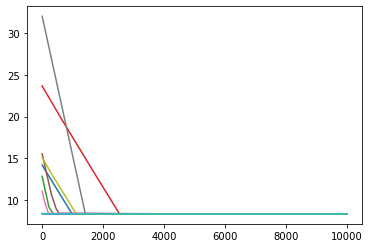

In [7]:
data = Dataset(n=10000, m = 10, k = 2, h2 =1)
sparse = list()

for i in trange(10):
    sparse.append(Decomp.projSparse(data.pathways))

for i in range(len(sparse)):
    for j in range(i):
        print(tools.evalAcc(sparse[i], sparse[j]))

## Archive

In [ ]:
def coordDescent(self):
    m = self.data.m
    k = self.k

    G = self.data.geno
    inter = self.data.inter
    Y = self.data.pheno#.reshape(-1, 1)

    thresh = 0.001

    # initialize pathways and weights
    weights = np.random.normal(0, 1, k * k).reshape(k, -1) 
    #weights = np.ones(k * k).reshape(k, -1) 
    weights = np.tril(weights, -1) + np.tril(weights, -1).T
    pathways = np.random.normal(0, 1, m * k).reshape(m, k)
    iterations = 0

    prevLoss = currentLoss = self.getLoss(pathways, weights)
    lossList = [currentLoss]

    while(True):
        # iteratively update each pathway
        for i in range(k):
            # compute constants
            mask = [True] * k
            mask[i] = False
            C1 = tools.outer(pathways, weights, skip=i).reshape(-1, 1)
            C1 = inter @ C1
            C2 = G @ np.sum(pathways[:,mask], axis=1, keepdims=True) 
            C = C1 + C2
            A = np.sum(G @ pathways @ np.diagflat(weights[i]), axis=1, keepdims=True)

            # equations from the first order conditions
            u1 = (4 * G.T @ (A*A*G)) + (4 * G.T @ (A*G)) + (G.T @ G)
            u2 = (2 * (A*G).T @ Y) + (G.T @ Y) - (2 * (A*G).T @ C) - (G.T @ C)
            u = linalg.inv(u1) @ u2
            pathways[:, i] = u.reshape(-1,)


        # iteratively fit weights
        for i in range(k):
            for j in range(i):
                ui = pathways[:,i]
                uj = pathways[:,j]

                # compute constants
                interacting = ((G @ ui) * (G @ uj)).reshape(-1, 1)
                C1 = tools.outer(pathways, weights) 
                C1 = C1 - weights[i, j] * (np.outer(ui, uj) + np.outer(uj, ui))
                C1 = inter @ C1.reshape(-1, 1)
                C2 = G @ np.sum(pathways, axis=1, keepdims=True) 
                C = C1 + C2

                # equation from the first order conditions
                weight = 1/2 * (interacting.T @ (Y - C))/(interacting.T @ interacting)
                weights[i, j] = weight
                weights[j, i] = weight    

        # monitor convergence
        iterations += 1

        prevLoss = currentLoss
        currentLoss = self.getLoss(pathways, weights)
        if iterations % 10 == 0: lossList.append(currentLoss)

        #if np.abs(currentLoss - prevLoss) < thresh: break
        if iterations > 700: break
        #if iterations % 10 == 0:
        #    print("(iterations,loss):", iterations, round(currentLoss, 3))

    return (lossList, iterations, pathways, weights)

In [ ]:
def projSparse(pathways):
    k = pathways.shape[1]
    init = torch.randn((k, k-1), requires_grad = True, dtype = torch.double)
    optimizer = optim.Adam([init])
    pathways = torch.from_numpy(pathways)
    lossList = list()

    tol = 1e-5

    for i in range(10000):
        row_sum = torch.sum(init, axis = 1).view(-1, 1)
        A = torch.cat((init, 1 - row_sum), axis = 1)
        optimizer.zero_grad()
        loss = torch.sum(torch.abs(pathways @ A))
        loss.backward()
        optimizer.step()
        lossList.append(loss.item())
    plt.plot(lossList)
    return (pathways @ A).detach().numpy()

In [ ]:
#########################
# iteratively weight update for coord descent
###########################


            for i in range(k):
                for j in range(i):
                    ui = pathways[:,i]
                    uj = pathways[:,j]

                    # compute constants
                    interacting = ((G @ ui) * (G @ uj)).reshape(-1, 1)
                    C1 = tools.outer(pathways, weights) 
                    C1 = C1 - weights[i, j] * (np.outer(ui, uj) + np.outer(uj, ui))
                    C1 = inter @ C1.reshape(-1, 1)
                    C2 = G @ np.sum(pathways, axis=1, keepdims=True) 
                    C = C1 + C2

                    # equation from the first order conditions
                    weight = 1/2 * (interacting.T @ (Y - C))/(interacting.T @ interacting)
                    weights[i, j] = weight
                    weights[j, i] = weight    

